# 1. Python Para Análise de Dados - Projeto Final do Curso
## 1.1. Um Modelo do Perfil de Inadimplência

Perfil do Adimplente e do Inadimplente

Cartão de crédito, crediário, cheque especial, empréstimos consignados e tantas outras modalidades de crédito são ferramentas de consumo poderosas. Quando bem utilizadas, potencializam a capacidade de compra e aumentam as chances de realizar sonhos de médio e longo prazo.

Porém, quando são utilizadas indiscriminadamente e de forma imediatista, podem trazer sérias consequências para a saúde financeira e para a vida do consumidor.

Pensando nisso, procuraramos mapear o perfil e a vida financeira dos consumidores adimplentes e inadimplentes, entendendo as visões e diferenças de comportamento frente às compras/conquistas e o endividamento, a saber: que fatores podem ser relacionados à decisão de não cumprir os compromissos financeiros assumidos? Será que o grau de escolaridade e a capacidade (ou falta) de planejamento financeiro têm relação direta com as contas em atraso e a restrição ao crédito? O que leva as pessoas a deixarem de pagar suas contas, mesmo quando poderiam fazê-lo? De que forma atitudes como “pensar mais no futuro”, pesquisar preços e parcelar compras relacionam-se com a adimplência ou a inadimplência?

Vamos estabelecer um perfil de adimplência e inadimplência a partir dos dados de crédito presentes no link:

https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/develop/dataset/credito.csv

Os dados estão em formato CSV e contém informações sobre clientes de uma instituição financeira. Nossas análises estarão dedicadas a explicar o comportamento da variável default, coluna 2 da base de dados. Quando um cliente recebeu default = 0, ele é adimplente. Quando um cliente recebeu default = 1, ele é inadimplente.

# 2. Importação de módulos

In [68]:
# Importação de pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set_style("whitegrid")

# 3. Importação e Leitura dos dados de crédito

In [24]:
# Vamos chamar nosso conjunto de dados pela variável bd(base de dados).
url = "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/develop/dataset/credito.csv"

bd = pd.read_csv(url, na_values='na')

In [25]:
bd.head(n=6)

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28
5,713061558,0,44,M,2,mestrado,casado,$40K - $60K,blue,36,3,2,1,"4.010,69","1.088,07",24


# 4. Exploração de dados
## 4.1. Estrutura

Vamos utilizar a função shape da biblioteca pandas para dimensionar nosso conjunto de dados em termos da quantidade de linhas e colunas.

In [26]:
bd.shape

(10127, 16)

Agora sabemos que temos no arquivo csv 10127 linhas e 16 colunas. A primeira linha, contém o cabeçalho das colunas.

Podemos contar quantos clientes são adimplentes, ou seja, default = 0.

In [27]:
bd[bd['default'] == 0].shape

(8500, 16)

De modo análogo, contamos a quantidade de clientes inadimplentes, fazendo:

In [28]:
bd[bd['default'] == 1].shape

(1627, 16)

Podemos atribuir à variáveis, a quantidade total de clientes, e os seguimentos de adimplentes e inadimplentes, de modo a obter valores proporcionais.

In [29]:
qtd_total, _ = bd.shape
qtd_adimplentes, _ = bd[bd['default'] == 0].shape
qtd_inadimplentes, _ = bd[bd['default'] == 1].shape

In [8]:
print(f"A proporção de clientes ADIMPLENTES é de {round(100 * qtd_adimplentes / qtd_total, 2)}%")
print(f"A proporção de clientes INADIMPLENTES é de {round(100 * qtd_inadimplentes/ qtd_total, 2)}%")

A proporção de clientes ADIMPLENTES é de 83.93%
A proporção de clientes INADIMPLENTES é de 16.07%


Vamos analisar o Schema de nossos dados. Que são os tipos de classes que os dados estão apresentados.

In [30]:
bd.dtypes

id                          int64
default                     int64
idade                       int64
sexo                       object
dependentes                 int64
escolaridade               object
estado_civil               object
salario_anual              object
tipo_cartao                object
meses_de_relacionamento     int64
qtd_produtos                int64
iteracoes_12m               int64
meses_inativo_12m           int64
limite_credito             object
valor_transacoes_12m       object
qtd_transacoes_12m          int64
dtype: object

Avaliando os tipos de dados das 16 colunas, verificamos que as colunas limite_credito e valor_transacoes_12m, contém valores do tipo string. O tipo adequado seria float.

Vamos fazer um breve resumo das variáveis atributos e numéricas. Começando pelas atributo.

In [31]:
bd.select_dtypes('object').describe().transpose()

,count,unique,top,freq
sexo,10127,2,F,5358
escolaridade,8608,5,mestrado,3128
estado_civil,9378,3,casado,4687
salario_anual,9015,5,menos que $40K,3561
tipo_cartao,10127,4,blue,9436
limite_credito,10127,9272,"1.438,21",11
valor_transacoes_12m,10127,10035,"3.851,51",3


E agora as variáveis numéricas:

In [32]:
bd.drop('id',   axis=1).select_dtypes('number').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
default,10127.0,0.160660,0.367235,0.0,0.0,0.0,0.0,1.0
idade,10127.0,46.325960,8.016814,26.0,41.0,46.0,52.0,73.0
dependentes,10127.0,2.346203,1.298908,0.0,1.0,2.0,3.0,5.0
meses_de_relacionamento,10127.0,35.928409,7.986416,13.0,31.0,36.0,40.0,56.0
qtd_produtos,10127.0,3.812580,1.554408,1.0,3.0,4.0,5.0,6.0
iteracoes_12m,10127.0,2.455317,1.106225,0.0,2.0,2.0,3.0,6.0
meses_inativo_12m,10127.0,2.341167,1.010622,0.0,2.0,2.0,3.0,6.0
qtd_transacoes_12m,10127.0,64.858695,23.472570,10.0,45.0,67.0,81.0,139.0


Vamos verificar se nosso banco de dados contém valores em branco.

In [33]:
bd.isna().any()

id                         False
default                    False
idade                      False
sexo                       False
dependentes                False
escolaridade                True
estado_civil                True
salario_anual               True
tipo_cartao                False
meses_de_relacionamento    False
qtd_produtos               False
iteracoes_12m              False
meses_inativo_12m          False
limite_credito             False
valor_transacoes_12m       False
qtd_transacoes_12m         False
dtype: bool

Há dados faltando nas colunas escolaridade, estado_civil e salario_anual. Vamos fazer um resumo estatístico para analisar o impacto da falta de dados e decidirmos se podemos prosseguir nossas análises.

# 4.3. Dados faltantes

In [34]:
def stats_dados_faltantes(bd: pd.DataFrame) ->  None:

  stats_dados_faltantes=  []
  for col in bd.columns:
    if bd[col].isna().any():
      qtd,_ = bd[bd[col].isna()].shape
      total,_ = bd.shape
      dict_dados_faltantes= {col: {'quantidade': qtd, "porcentagem": round(100 *  qtd/total, 2)}}
      stats_dados_faltantes.append(dict_dados_faltantes)

  for stat in stats_dados_faltantes:
    print(stat)

Com a função stats_dados_faltantes, podemos analisar o impacto da falta de dados tanto para o conjunto geral, como nos subconjuntos dos adimplentes e dos inadimplentes.

In [35]:
stats_dados_faltantes(bd=bd)

{'escolaridade': {'quantidade': 1519, 'porcentagem': 15.0}}
{'estado_civil': {'quantidade': 749, 'porcentagem': 7.4}}
{'salario_anual': {'quantidade': 1112, 'porcentagem': 10.98}}


Na coluna escolaridade, 15% dos dados estão faltando. Enquanto que na coluna estado_civil, os dados faltantes representam mais de 7% e o salario_atual responde por 11% da falta de dados. Vamos verificar se as proporções são mantidas quando analisamos os dados dos clientes adimplentes e inadimplentes.

In [36]:
stats_dados_faltantes(bd=bd[bd['default']==0])

{'escolaridade': {'quantidade': 1263, 'porcentagem': 14.86}}
{'estado_civil': {'quantidade': 620, 'porcentagem': 7.29}}
{'salario_anual': {'quantidade': 925, 'porcentagem': 10.88}}


In [37]:
stats_dados_faltantes(bd=bd[bd['default']==1])

{'escolaridade': {'quantidade': 256, 'porcentagem': 15.73}}
{'estado_civil': {'quantidade': 129, 'porcentagem': 7.93}}
{'salario_anual': {'quantidade': 187, 'porcentagem': 11.49}}


# 5. Transformação e limpeza de dados
## 5.1. Correção de schema

In [41]:
# Definindo a função que lida com diferentes tipos de dados
def fn(valor):
    if isinstance(valor, str):
        return float(valor.replace(".", "").replace(",", "."))
    return valor

# Aplicando a função às colunas cujos dados pertencem à classe float e 
# estam com outros tipos 
bd['valor_transacoes_12m'] = bd['valor_transacoes_12m'].apply(fn)
bd['limite_credito'] =  bd['limite_credito'].apply(fn)

print("Colunas atualizadas com sucesso!")

Colunas atualizadas com sucesso!


In [42]:
bd.dtypes

id                           int64
default                      int64
idade                        int64
sexo                        object
dependentes                  int64
escolaridade                object
estado_civil                object
salario_anual               object
tipo_cartao                 object
meses_de_relacionamento      int64
qtd_produtos                 int64
iteracoes_12m                int64
meses_inativo_12m            int64
limite_credito             float64
valor_transacoes_12m       float64
qtd_transacoes_12m           int64
dtype: object

## 5.2. Exclusão de dados faltantes


In [44]:
bd.dropna(inplace=True)

In [45]:
bd.shape

(7081, 16)

In [46]:
bd[bd['default'] == 0].shape

(5968, 16)

In [47]:
bd[bd['default'] == 1].shape

(1113, 16)

Após exclusão dos registros com dados faltantes, devemos observar a proprocionalidade das principais classificações do nosso estudo: clientes adimplentes e inadimplentes.

In [49]:
qtd_total_novo, _ = bd.shape
qtd_adimplentes_novo, _ = bd[bd['default'] == 0].shape
qtd_inadimplentes_novo, _ = bd[bd['default'] == 1].shape

In [51]:
print(f"A proporcão de adimplentes ANTES da exclusão é de {round(100 * qtd_adimplentes/ qtd_total, 2)}%")
print(f"A proporcão de adimplentes DEPOIS da exclusão é de {round(100 * qtd_adimplentes_novo / qtd_total_novo, 2)}%")

print("")

print(f"A proporcão de INadimplentes ANTES da exclusão é de {round(100 * qtd_inadimplentes / qtd_total, 2)}%")
print(f"A proporcão de INadimplentes DEPOIS da exclusão é de {round(100 * qtd_inadimplentes_novo / qtd_total_novo, 2)}%")

A proporcão de adimplentes ANTES da exclusão é de 83.93%
A proporcão de adimplentes DEPOIS da exclusão é de 84.28%

A proporcão de INadimplentes ANTES da exclusão é de 16.07%
A proporcão de INadimplentes DEPOIS da exclusão é de 15.72%


Após exclusão dos registros incompletos, restaram **7081** registros com dados completamente preenchidos. Proporcionalmente, o **default** manteve-se muito perto dos percentuais anteriormente obtidos. Ou seja, a limpeza da base de nosso dataframe não interfere na representatividade dos dados. O que é muito bom para o andamento do projeto.

# 6. Visões Gráficas
## 6.1. Variáveis Categóricas

In [52]:
bd_adimplentes = bd[bd['default']==0]
bd_inadimplentes = bd[bd['default']==1]

In [53]:
bd.select_dtypes('object').head(n=5)

,sexo,escolaridade,estado_civil,salario_anual,tipo_cartao
0,M,ensino medio,casado,$60K - $80K,blue
1,F,mestrado,solteiro,menos que $40K,blue
2,M,mestrado,casado,$80K - $120K,blue
4,M,sem educacao formal,casado,$60K - $80K,blue
5,M,mestrado,casado,$40K - $60K,blue


## * Escolaridade

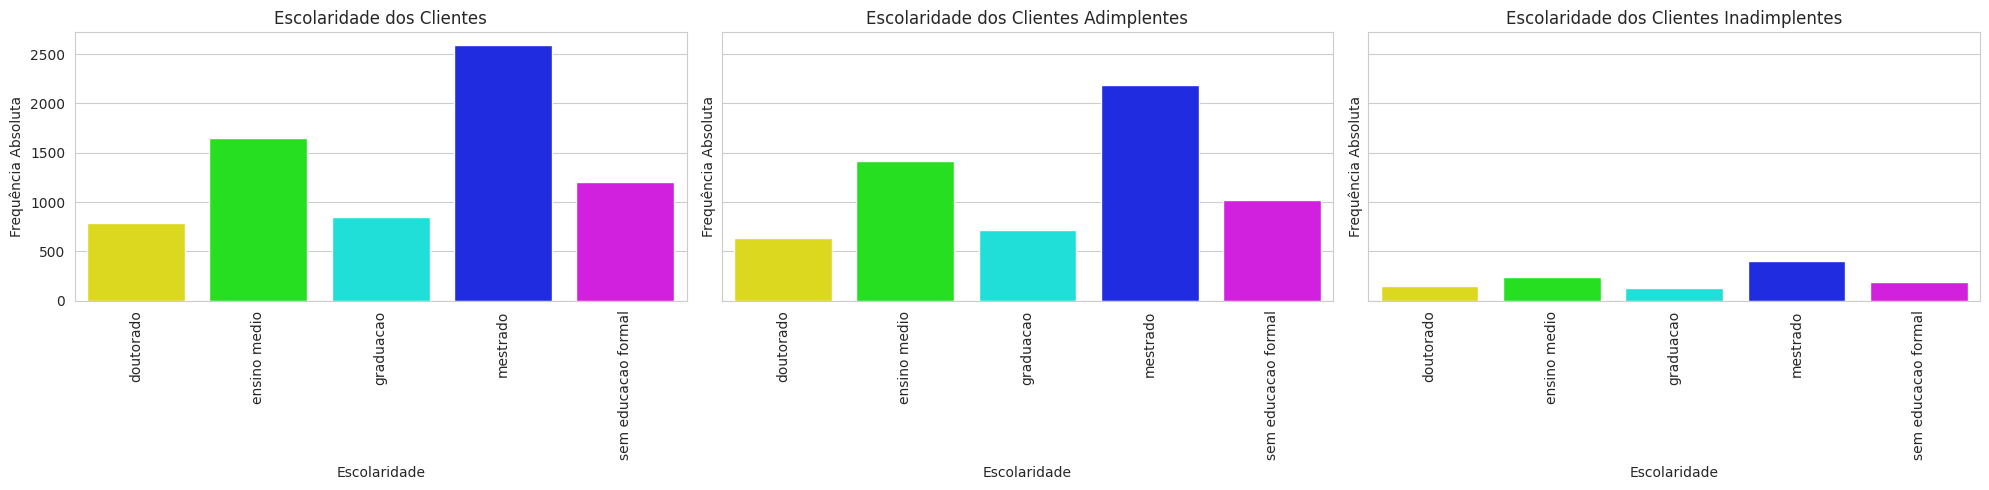

In [56]:
# Definindo a coluna de interesse
coluna = 'escolaridade'

# Definir uma paleta de cores
paleta_cores = sns.color_palette("hsv", len(bd[coluna].unique()))

titulos = ['Escolaridade dos Clientes', 'Escolaridade dos Clientes Adimplentes', 'Escolaridade dos Clientes Inadimplentes']

figura, eixos = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

max_y = 0

for eixo, (dataframe, titulo) in enumerate(zip([bd, bd_adimplentes, bd_inadimplentes], titulos)):
    # Calcular frequências
    bd_to_plot = dataframe[coluna].value_counts().to_frame(name='frequencia_absoluta')
    bd_to_plot[coluna] = bd_to_plot.index
    bd_to_plot.reset_index(drop=True, inplace=True)  # Redefinir o índice para evitar ambiguidade

    # Verificar o conteúdo do DataFrame
    #print(f"DataFrame para {titulo}:\n", bd_to_plot.head())

    # Ordenar os valores
    bd_to_plot.sort_values(by=[coluna], inplace=True)

    # Plotar os dados
    f = sns.barplot(x=bd_to_plot[coluna], y=bd_to_plot['frequencia_absoluta'], ax=eixos[eixo], palette=paleta_cores)
    f.set(title=titulo, xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')
    f.set_xticks(range(len(bd_to_plot[coluna])))
    f.set_xticklabels(labels=bd_to_plot[coluna], rotation=90)

    _,max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

    eixo += 1

# Ajustar layout
plt.tight_layout()
figura.show()

*Como vemos no primeiro gráfico a maioria dos clientes da instituição financeira possui nível mestrado de escolaridade. Observando os clientes adimplentes, notamos uma predominância similar.A mesma condição pode ser verificada, também, quanto aos clientes Inadimplentes. Nota-se ainda que, aproximadamente, 84% dos clientes são ADIMPLENTES, enquanto 16% são inadimplentes.*

*Esses dados sugerem que a escolaridade pode ter uma correlação com a adimplência. Essas informações podem ser valiosas para criar estratégias mais eficazes de gestão de crédito.*

## * Salário Anual

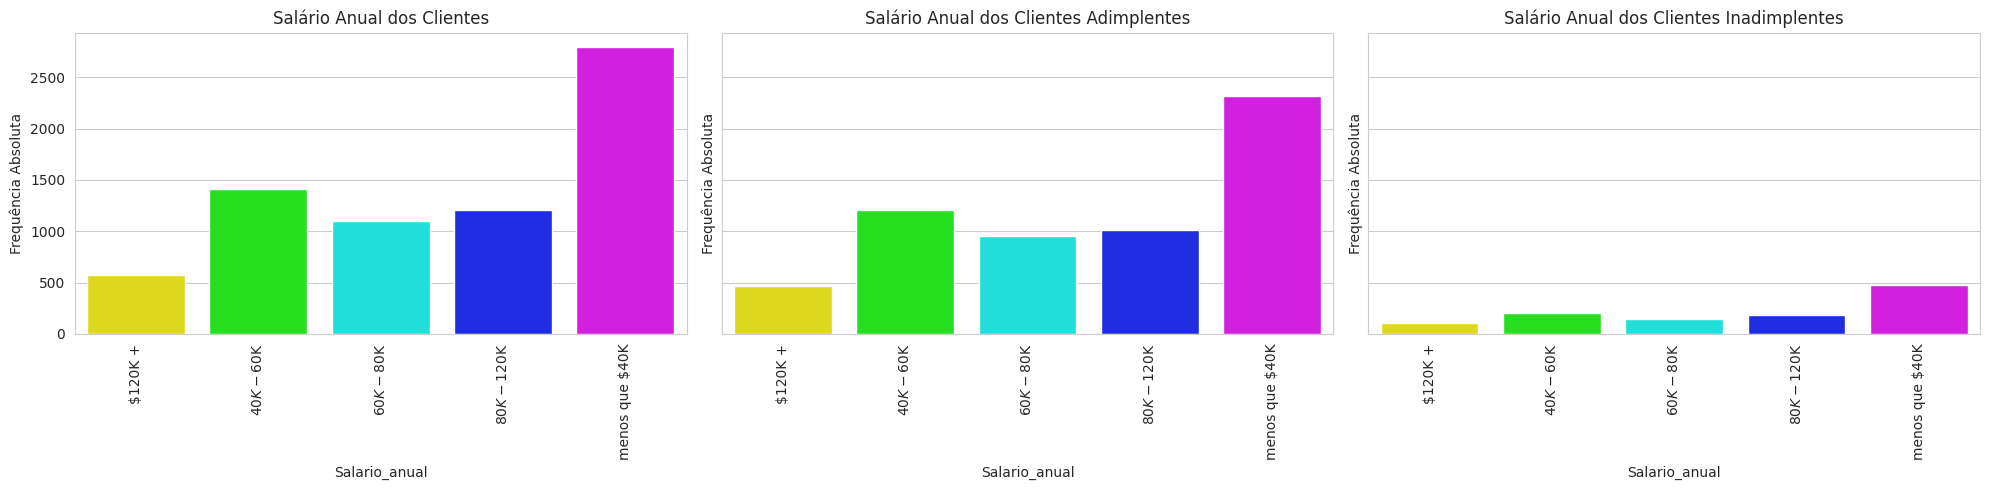

In [55]:
# Definindo a coluna de interesse
coluna = 'salario_anual'

# Definir uma paleta de cores
paleta_cores = sns.color_palette("hsv", len(bd[coluna].unique()))

titulos = ['Salário Anual dos Clientes', 'Salário Anual dos Clientes Adimplentes', 'Salário Anual dos Clientes Inadimplentes']

figura, eixos = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

max_y = 0

for eixo, (dataframe, titulo) in enumerate(zip([bd, bd_adimplentes, bd_inadimplentes], titulos)):
    # Calcular frequências
    bd_to_plot = dataframe[coluna].value_counts().to_frame(name='frequencia_absoluta')
    bd_to_plot[coluna] = bd_to_plot.index
    bd_to_plot.reset_index(drop=True, inplace=True)  # Redefinir o índice para evitar ambiguidade

    # Verificar o conteúdo do DataFrame
    #print(f"DataFrame para {titulo}:\n", bd_to_plot.head())

    # Ordenar os valores
    bd_to_plot.sort_values(by=[coluna], inplace=True)

    # Plotar os dados
    f = sns.barplot(x=bd_to_plot[coluna], y=bd_to_plot['frequencia_absoluta'], ax=eixos[eixo], palette=paleta_cores)
    f.set(title=titulo, xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')
    f.set_xticks(range(len(bd_to_plot[coluna])))
    f.set_xticklabels(labels=bd_to_plot[coluna], rotation=90)

    _,max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

    eixo += 1

# Ajustar layout
plt.tight_layout()
figura.show()

*Analisando-se a classificação, segundo o salário anual, nota-se que a maioria dos clientes possui renda anual menor que 40 mil reais. Condição verificada para os clientes adimplentes e também para os clientes inadimplentes. Onde cerca de 500 clientes encontram-se inadimplentes.*

## * Estado Civil

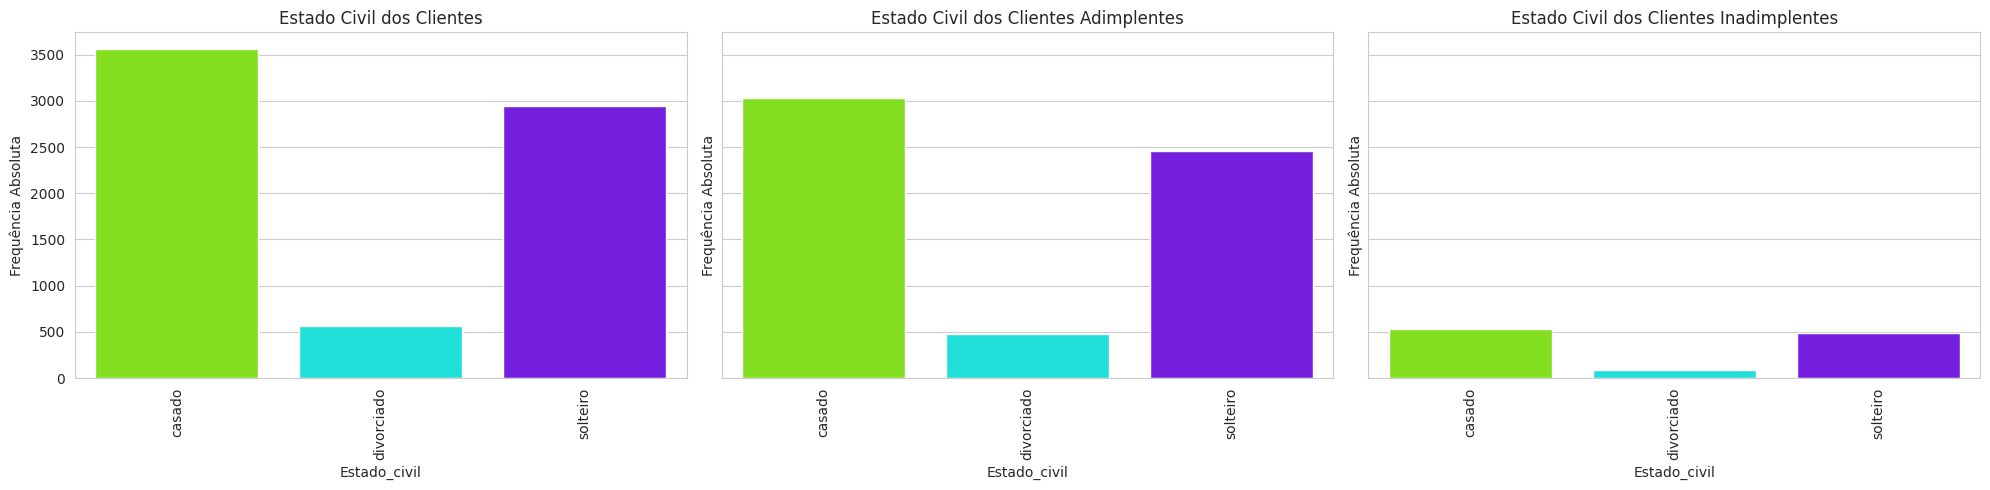

In [57]:
# Definindo a coluna de interesse
coluna = 'estado_civil'

# Definir uma paleta de cores
paleta_cores = sns.color_palette("hsv", len(bd[coluna].unique()))

titulos = ['Estado Civil dos Clientes', 'Estado Civil dos Clientes Adimplentes', 'Estado Civil dos Clientes Inadimplentes']

figura, eixos = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

max_y = 0

for eixo, (dataframe, titulo) in enumerate(zip([bd, bd_adimplentes, bd_inadimplentes], titulos)):
    # Calcular frequências
    bd_to_plot = dataframe[coluna].value_counts().to_frame(name='frequencia_absoluta')
    bd_to_plot[coluna] = bd_to_plot.index
    bd_to_plot.reset_index(drop=True, inplace=True)  # Redefinir o índice para evitar ambiguidade

    # Verificar o conteúdo do DataFrame
    #print(f"DataFrame para {titulo}:\n", bd_to_plot.head())

    # Ordenar os valores
    bd_to_plot.sort_values(by=[coluna], inplace=True)

    # Plotar os dados
    f = sns.barplot(x=bd_to_plot[coluna], y=bd_to_plot['frequencia_absoluta'], ax=eixos[eixo], palette=paleta_cores)
    f.set(title=titulo, xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')
    f.set_xticks(range(len(bd_to_plot[coluna])))
    f.set_xticklabels(labels=bd_to_plot[coluna], rotation=90)

    _,max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

    eixo += 1

# Ajustar layout
plt.tight_layout()
figura.show()

*Nota-se, no gráfico acima, que os divorciados são menos inadimplentes que solteiros e casados, que são proporcionalmente iguais. Pensão alimentícia(?).*

## * Tipo de Cartão

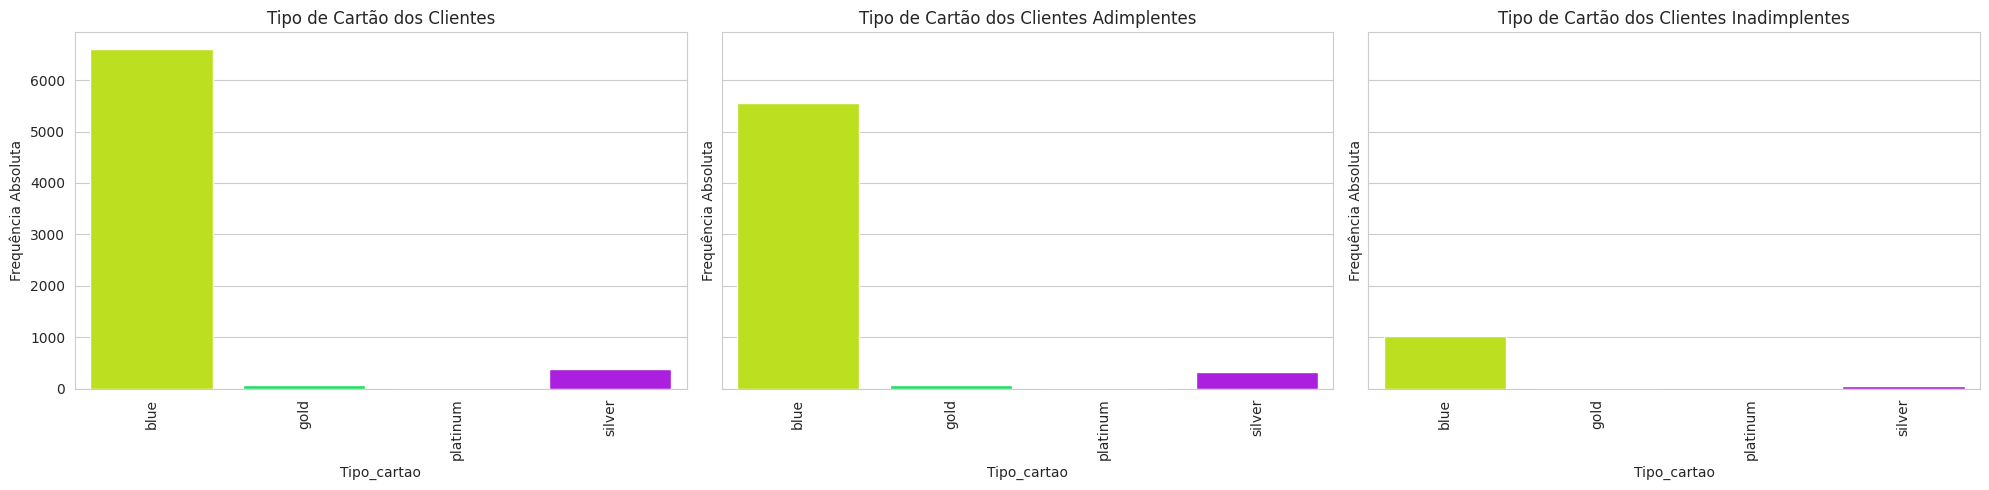

In [58]:
# Definindo a coluna de interesse
coluna = 'tipo_cartao'

# Definir uma paleta de cores
paleta_cores = sns.color_palette("hsv", len(bd[coluna].unique()))

titulos = ['Tipo de Cartão dos Clientes', 'Tipo de Cartão dos Clientes Adimplentes', 'Tipo de Cartão dos Clientes Inadimplentes']

figura, eixos = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

max_y = 0

for eixo, (dataframe, titulo) in enumerate(zip([bd, bd_adimplentes, bd_inadimplentes], titulos)):
    # Calcular frequências
    bd_to_plot = dataframe[coluna].value_counts().to_frame(name='frequencia_absoluta')
    bd_to_plot[coluna] = bd_to_plot.index
    bd_to_plot.reset_index(drop=True, inplace=True)  # Redefinir o índice para evitar ambiguidade

    # Verificar o conteúdo do DataFrame
    #print(f"DataFrame para {titulo}:\n", bd_to_plot.head())

    # Ordenar os valores
    bd_to_plot.sort_values(by=[coluna], inplace=True)

    # Plotar os dados
    f = sns.barplot(x=bd_to_plot[coluna], y=bd_to_plot['frequencia_absoluta'], ax=eixos[eixo], palette=paleta_cores)
    f.set(title=titulo, xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')
    f.set_xticks(range(len(bd_to_plot[coluna])))
    f.set_xticklabels(labels=bd_to_plot[coluna], rotation=90)

    _,max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

    eixo += 1

# Ajustar layout
plt.tight_layout()
figura.show()

*Analisando-se os dados segundo o tipo de cartão de crédito, nota-se que clientes com cartão azul, tem predominância de inadimplência.*

# 6.2. Visualizações Numéricas

## * Quantidade de Transações nos Últimos 12 Meses

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


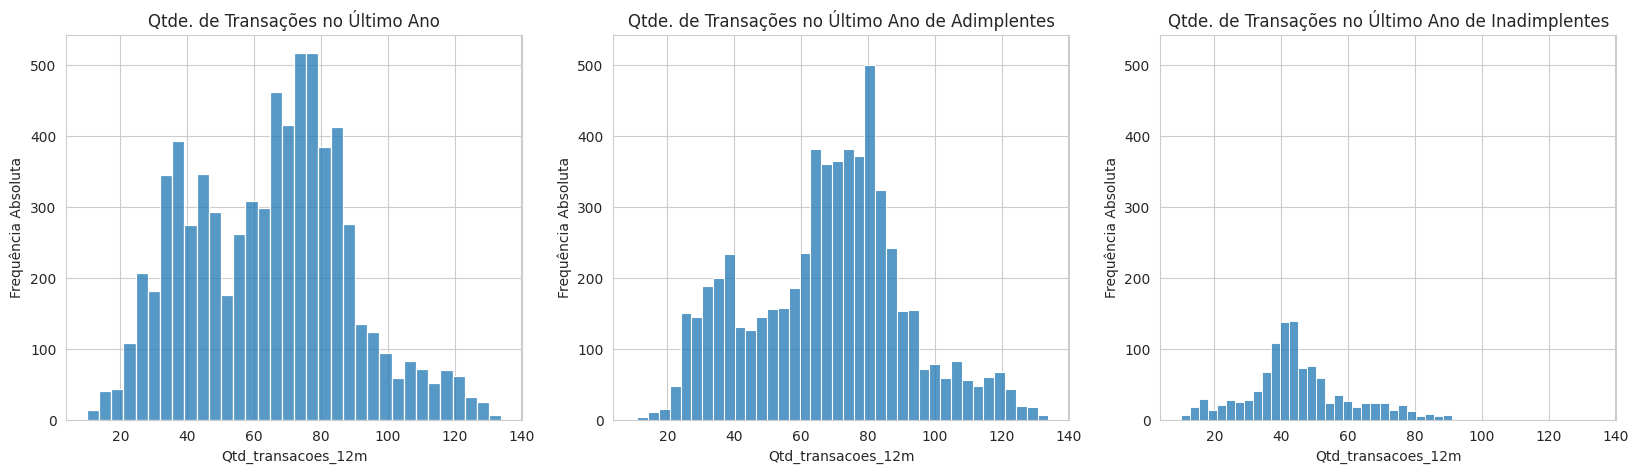

In [63]:
# Definindo a coluna de interesse
coluna = 'qtd_transacoes_12m'

# Definir uma paleta de cores
paleta_cores = sns.color_palette("hsv", len(bd[coluna].unique()))

titulos = ['Qtde. de Transações no Último Ano', 'Qtde. de Transações no Último Ano de Adimplentes', 'Qtde. de Transações no Último Ano de Inadimplentes']

eixo = 0
max_y = 0
figura, eixos = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

max_y = 0

for dataframe, eixo, titulo in zip([bd, bd_adimplentes, bd_inadimplentes], eixos, titulos):

    # Plotar os dados
    f = sns.histplot(x=coluna, data=dataframe, stat='count', ax=eixo)
    f.set(title=titulo, xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')

    _,max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

figura.show()

*Segundo o volume de transações no período de um ano, percebe-se que clientes inadimplentes, fazem em média 40 transações ao ano. Enquanto que os clientes adimplentes, transacionam em média o dobro desse valor, 80 transações ao ano.*

## * Valor das Transações nos Últimos 12 Meses

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


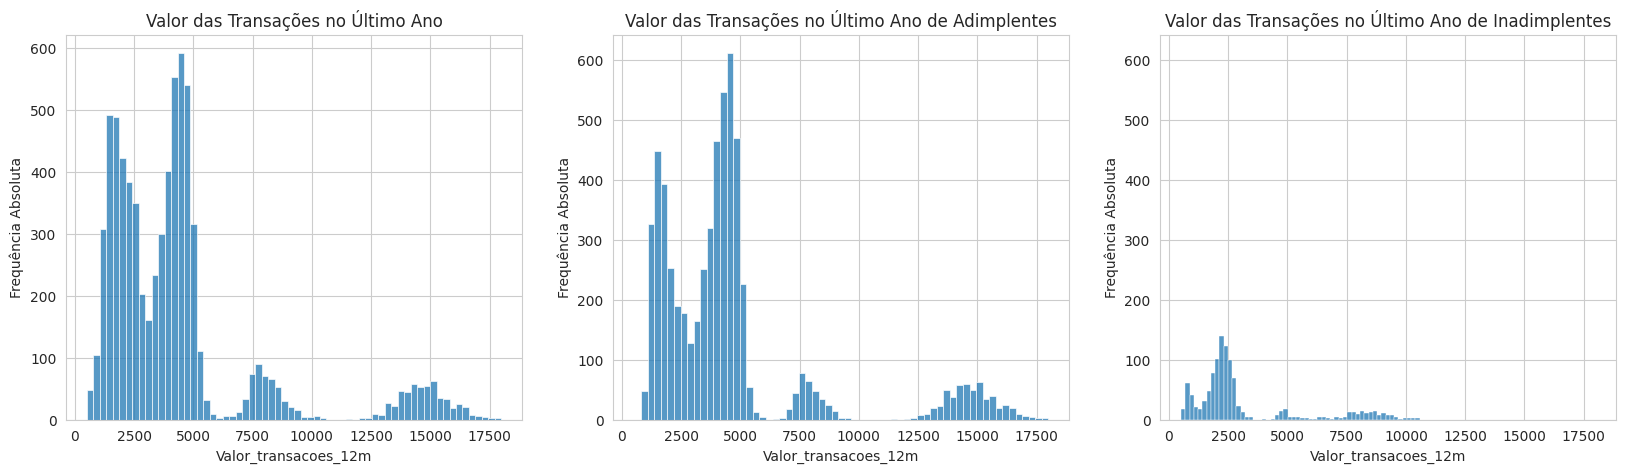

In [64]:
# Definindo a coluna de interesse
coluna = 'valor_transacoes_12m'

# Definir uma paleta de cores
paleta_cores = sns.color_palette("hsv", len(bd[coluna].unique()))

titulos = ['Valor das Transações no Último Ano', 'Valor das Transações no Último Ano de Adimplentes', 'Valor das Transações no Último Ano de Inadimplentes']

eixo = 0
max_y = 0
figura, eixos = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

max_y = 0

for dataframe, eixo, titulo in zip([bd, bd_adimplentes, bd_inadimplentes], eixos, titulos):

    # Plotar os dados
    f = sns.histplot(x=coluna, data=dataframe, stat='count', ax=eixo)
    f.set(title=titulo, xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')

    _,max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

figura.show()

*Classificando-se os dados com base no volume financeiro envolvido em um ano de transações, clientes inadimplentes tendem a movimetar, em média dois mil e quinhentos reais. Enquanto que os clientes adimplentes movimentam em média cinco mil reais.*

## * Valor de Transações nos Últimos 12 Meses X Quantidade de Transações nos Últimos 12 Meses.

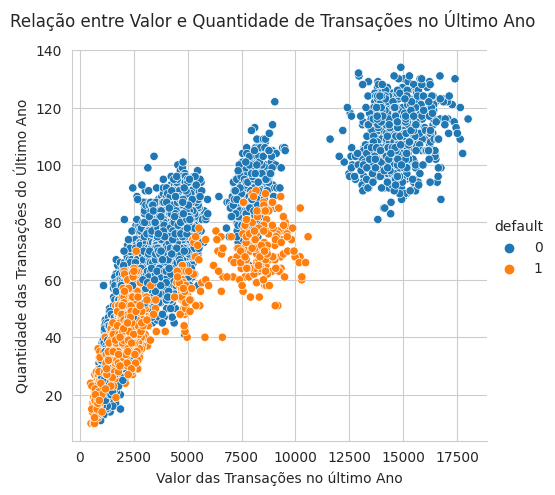

In [65]:
f = sns.relplot(x='valor_transacoes_12m', y='qtd_transacoes_12m', data=bd, hue='default')

# Ajustar o título e os rótulos dos eixos
f.fig.suptitle('Relação entre Valor e Quantidade de Transações no Último Ano')
f.set_axis_labels('Valor das Transações no último Ano', 'Quantidade das Transações do Último Ano')

# Ajustar a posição do título para evitar sobreposição
plt.subplots_adjust(top=0.9)

# Mostrar o gráfico
plt.show()


*Avaliando-se a correlação entre o número de transações e o volume de dinheiro movimentado, nota-se um grupo que faz muitas transações com quantias elevadas. Nesse grupo, todos os clientes são **adimplentes***.

*Das análises feitas, podemos concluir que um cliente com cartão gold ou platinum, que movimenta bastante transações e com valores elevados e possua nível de escolaridade de graduação ou doutorado, é potencialmente adimplente e pode ter seu pedido de crédito financeiro concedido.*

# 7. Modelo de Predição Baseado em Machine Learning

**Apenas uma pequena aventura no imenso mundo do Machine Learning**

In [72]:
# Pré-processamento dos Dados
bd = bd.dropna()  # Remover linhas com valores faltantes
bd = pd.get_dummies(bd, drop_first=True)  # Codificar variáveis categóricas

# Definir variáveis alvo e preditoras
X = bd[['valor_transacoes_12m', 'qtd_transacoes_12m', 'dependentes', 'qtd_produtos']]
y = bd['default']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Construir a Rede Neural
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Fazer previsões
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Avaliar o modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Avaliar um novo cliente
novo_cliente = [[828343084, 48, 4, 3000, 1000, 37]]

# Supondo que 'novo_cliente' seja um DataFrame com os dados do cliente
novo_cliente_encoded = pd.get_dummies(pd.DataFrame(novo_cliente))

# Garanta que todas as colunas do treinamento estejam no novo cliente
novo_cliente_encoded = novo_cliente_encoded.reindex(columns=X.columns, fill_value=0)

# Normalizar os dados
novo_cliente_scaled = scaler.transform(novo_cliente_encoded)  # Uso o mesmo scaler do código original

# Fazer a previsão usando o modelo treinado
predicted_class = (model.predict(novo_cliente_scaled) > 0.5).astype("int32")

# Interpretar o resultado da predição
if predicted_class == 1:
    result_message = "potencialmente ADIMPLENTE"
else:
    result_message = "potencialmente INADIMPLENTE"

# Imprimir a mensagem com o resultado da predição
print("Predicted class for new client:", predicted_class, " - ", result_message)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6722 - loss: 0.6066 - val_accuracy: 0.8438 - val_loss: 0.3750
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8449 - loss: 0.3777 - val_accuracy: 0.8700 - val_loss: 0.3381
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.3462 - val_accuracy: 0.8730 - val_loss: 0.3113
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.3241 - val_accuracy: 0.8770 - val_loss: 0.2935
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.3056 - val_accuracy: 0.8730 - val_loss: 0.2812
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.2956 - val_accuracy: 0.8841 - val_loss: 0.2801
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.2783 - val_accuracy: 0.8821 - val_loss: 0.2774
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.2970 - val_accuracy: 0.8831 - val_

# 8. Storytelling

Segundo o volume de transações no período de um ano, percebe-se que clientes inadimplentes, fazem em média 40 transações ao ano. Enquanto que os clientes adimplentes, transacionam em média o dobro desse valor, 80 transações ao ano.

image.png

Classificando-se os dados com base no volume financeiro envolvido em um ano de transações, clientes inadimplentes tendem a movimetar, em média dois mil e quinhentos reais. Enquanto que os clientes adimplentes movimentam em média cinco mil reais,

image.png

Avalinado-se a correlação entre o número de transações e o volume de dinheiro movimentado, nota-se um grupo que faz muitas transações com quantias elevadas.

image.png

Das análises feitas, podemos concluir que um cliente com cartão gold ou platinum, que movimenta bastante transações e com valores elevados e possua nível de escolaridade de graduação ou doutorado, é potencialmente adimplente e pode ter seu pedido de crédito financeiro concedido.ão de crédito, crediário, cheque especial, empréstimos consignados e tantas outras modalidades de crédito são ferramentas de consumo poderosas. Quando bem utilizadas, potencializam a capacidade de compra e aumentam as chances de realizar sonhos de médio e longo prazo.

Porém, quando são utilizadas indiscriminadamente e de forma imediatista, podem trazer sérias consequências para a saúde financeira e para a vida do consumidor.

Pensando nisso, procuraramos mapear o perfil e a vida financeira dos consumidores adimplentes e inadimplentes, entendendo as visões e diferenças de comportamento frente às compras/conquistas e o endividamento, a saber: que fatores podem ser relacionados à decisão de não cumprir os compromissos financeiros assumidos?

Vamos explorar a escolaridade dos clientes de uma instituição financeira, divididos em três grupos: total, adimplentes e inadimplentes.

image.png

Como vemos no primeiro gráfico a maioria dos clientes da instituição financeira possui nível mestrado de escolaridade. Observando os clientes adimplentes, notamos uma predominância similar.A mesma condição pode ser verificada, também, quanto aos clientes Inadimplentes. Nota-se ainda que, aproximadamente, 84% dos clientes são ADIMPLENTES, enquanto 16% são inadimplentes.

Esses dados sugerem que a escolaridade pode ter uma correlação com a adimplência. Essas informações podem ser valiosas para criar estratégias mais eficazes de gestão de crédito.

Analisando-se a classificação, segundo o salário anual, nota-se que a maioria dos clientes possui renda anual menor que 40 mil reais. Condição verificada para os clientes adimplentes e também para os clientes inadimplentes. Onde cerca de 500 clientes encontram-se inadimplentes.

image.png

Nota-se, no gráfico abaixo, que os divorciados são menos inadimplentes que solteiros e casados, que são proporcionalmente iguais. Pensão alimentícia(?).

image.png

Analisando-se os dados segundo o tipo de cartão de crédito, nota-se que clientes com cartão azul, tem predominância de inadimplência.

image.png

Segundo o volume de transações no período de um ano, percebe-se que clientes inadimplentes, fazem em média 40 transações ao ano. Enquanto que os clientes adimplentes, transacionam em média o dobro desse valor, 80 transações ao ano.

image.png

Classificando-se os dados com base no volume financeiro envolvido em um ano de transações, clientes inadimplentes tendem a movimetar, em média dois mil e quinhentos reais. Enquanto que os clientes adimplentes movimentam em média cinco mil reais,

image.png

Avalinado-se a correlação entre o número de transações e o volume de dinheiro movimentado, nota-se um grupo que faz muitas transações com quantias elevadas.

image.png

Das análises feitas, podemos concluir que um cliente com cartão gold ou platinum, que movimenta bastante transações e com valores elevados e possua nível de escolaridade de graduação ou doutorado, é potencialmente adimplente e pode ter seu pedido de crédito financeiro concedido.